In [3]:
!pip install colour-demosaicing

     |████████████████████████████████| 3.3MB 1.4MB/s 
     |████████████████████████████████| 1.6MB 36.5MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import os

from pathlib import Path


import numpy as np
import torchvision
import matplotlib.pyplot as plt

import torch
from torchvision import transforms, models

from albumentations import Compose, ToGray, Normalize, RandomCrop, Resize
#from albumentations.pytorch import ToTensor
from torch.utils.data import Dataset, DataLoader

from PIL import Image
from colour_demosaicing import demosaicing_CFA_Bayer_Menon2007

import random
print(os.listdir())

['data_preprocess.ipynb', '.DS_Store', 'CNN.ipynb', 'raw_images', '.ipynb_checkpoints', '.git', 'data']


In [11]:
data_root = '/Users/mac/GIT/dl_noise_est/data/'

In [14]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['awgn', 'bayer']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(data_root, dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, f"{class_name}/")
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(data_root, train_dir, class_name) 
        else:
            dest_dir = os.path.join(data_root, val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 451/451 [00:01<00:00, 438.48it/s]


In [0]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
# Разбить на val, train: DONE

# Переписать ImageDataset так, чтобы он мог работать с уже готовыми картинками!

# добавить аугментацию (кропы)

# перепроверить код

# подписать оси, сделать красивыми графики

# сделать cosine lr decay

In [0]:
class ImageDataset(Dataset):

    def __init__(self, image_paths, augmentations=None, max_sigma=15):
        super().__init__()
        self.image_paths = image_paths
        self.size = len(image_paths)
        self.max_sigma = max_sigma
        self.augmentations = augmentations

    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        #image_idx = np.random.randint(0, self.size)
        image = self.load_image(self.image_paths[idx])
        #print(idx)
        
        mode = self.get_random_mode()
        sigma = self.get_random_sigma()
        
        if mode == 'awgn':
            noisy_im = get_awgn_image(image, sigma)
        else:
            noisy_im = mosaic_awgn_demosaic(image, sigma)
            
        noisy_im = np.array(noisy_im / 255., dtype='float32')
        
        label = 0 if mode == 'bayer' else 1
        
        return transform(self.augmentations(image=noisy_im)['image']), label, sigma

    def load_image(self, image_path):
        #print('Opening image... ', image_path )
        image = Image.open(image_path)
        image.load()
        # TODO дублирование по каналам, если изображение полутоновое
        return np.array(image)
    
    def get_random_mode(self):
        return np.random.choice(['awgn', 'bayer'])
    
    def get_random_sigma(self):
        return np.random.randint(0, self.max_sigma)

## Аугментация и деление на обучение и валидацию

In [6]:
class_names = ['bayer', 'awgn']

train_transforms = Compose([
    Resize(224,224),
    #RandomCrop(224,224),
    ToGray(p=1.0),
])

val_transforms = Compose([
    Resize(224,224),
    ToGray(p=1.0),
])

IMAGES_DIR = Path('drive/My Drive/dl_noise_classification/raw_images/')
im_paths = list(IMAGES_DIR.rglob('*.jpg'))
#print(im_paths[:10])
n_images = len(im_paths)
n_train = int(n_images * 0.8)

train_paths = im_paths[:20]
val_paths = im_paths[20:30]
print("Train size: {}\nValid size: {}".format(len(train_paths), len(val_paths)))

Train size: 20
Valid size: 10


In [0]:
train_dataset = ImageDataset(train_paths, train_transforms)
val_dataset = ImageDataset(val_paths, val_transforms)

batch_size = 10
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

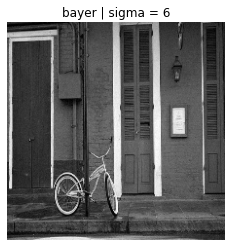

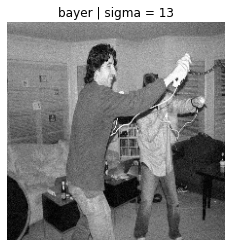

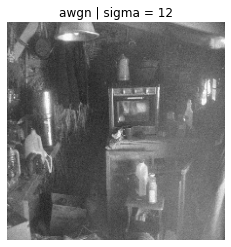

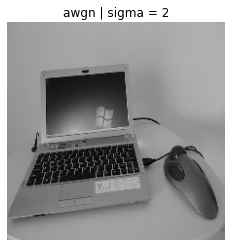

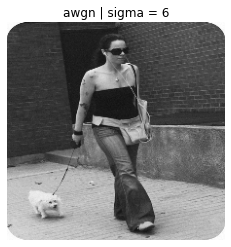

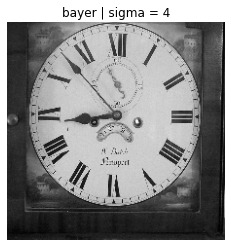

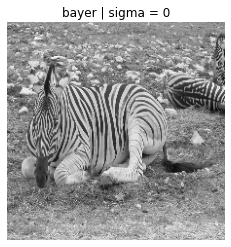

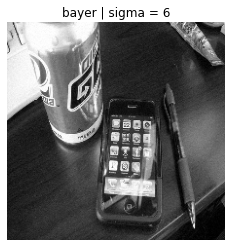

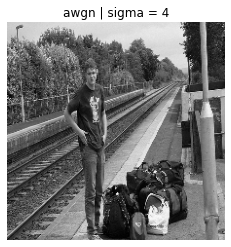

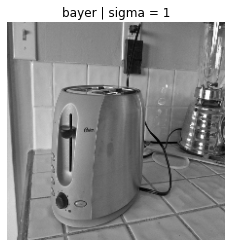

In [8]:
def show_input(input_tensor, title=''):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = input_tensor.numpy().transpose((1, 2, 0))
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.axis('off')
    plt.show()
    #plt.pause(0.001)

X_batch, y_batch, s_batch = next(iter(train_dataloader))

for x_item, y_item, sigma in zip(X_batch, y_batch, s_batch):
    show_input(x_item, title="{} | sigma = {}".format(class_names[y_item], sigma))

## 25 Случайных картинок из Train Dataset

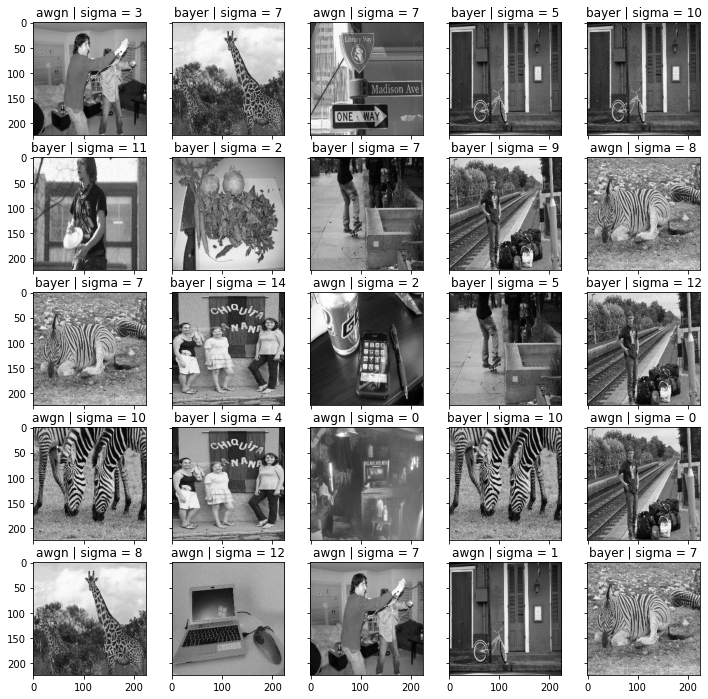

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

fig, ax = plt.subplots(nrows=5, ncols=5,figsize=(12, 12), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_plate = int(np.random.uniform(0, len(train_paths)))
    im_val, label, sigma = train_dataset[random_plate]
    imshow(im_val.data.cpu(), title="{} | sigma = {}".format(class_names[label], sigma), plt_ax=fig_x)

In [0]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    val_loss = []
    train_loss = []
    best_val_loss = np.inf
    best_train_loss = np.inf
    best_val_model = {}
    best_train_model = {}

    for epoch in range(num_epochs):

        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # training mode
            else:
                dataloader = val_dataloader
                model.eval()   # evaluate mode (dropout + bn)

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels, _ in dataloader:
                #print(inputs, labels)
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase=='train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.cpu().item()
                running_acc += (preds_class.cpu() == labels.cpu().data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            if phase == 'val' and best_val_loss > epoch_loss:
                best_val_model = model.state_dict()
                best_val_loss = epoch_loss
            if phase == 'train' and best_train_loss > epoch_loss:
                best_train_model = model.state_dict()
                best_train_loss = epoch_loss
            epoch_acc = running_acc / len(dataloader)
            history = train_loss if phase == 'train' else val_loss
            history.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}\n best: {}'.format(phase, epoch_loss, epoch_acc, best_val_loss), flush=True)

    return train_loss, val_loss, best_train_model, best_val_model

## Обучение сети VGG16 с последним линейным слоем

In [11]:
#model = models.resnet152(pretrained=True)
model = models.vgg16(pretrained=True)
#model.fc = torch.nn.Linear(model.fc.in_features, 2)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


AttributeError: ignored

In [18]:
list(model.classifier.children())

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=1000, bias=True)]

In [0]:
num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(num_features, 2)]) # Add our layer with 2 outputs
model.classifier = torch.nn.Sequential(*features)

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

cuda:0


In [0]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Decay LR by a factor of 0.5 every 20 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

In [32]:
loss_train_history, loss_val_history, best_train_model, best_val_model = train_model(
    model, 
    loss, 
    optimizer, 
    scheduler, 
    num_epochs=500)

Epoch 0/499:


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.6618 Acc: 0.6000
 best: inf
val Loss: 0.6978 Acc: 0.5000
 best: 0.6977959871292114
Epoch 1/499:
train Loss: 0.7980 Acc: 0.4000
 best: 0.6977959871292114
val Loss: 0.7572 Acc: 0.4000
 best: 0.6977959871292114
Epoch 2/499:
train Loss: 0.8762 Acc: 0.3500
 best: 0.6977959871292114
val Loss: 0.6947 Acc: 0.5000
 best: 0.6946883201599121
Epoch 3/499:
train Loss: 0.6454 Acc: 0.6500
 best: 0.6946883201599121
val Loss: 0.7031 Acc: 0.3000
 best: 0.6946883201599121
Epoch 4/499:
train Loss: 0.8041 Acc: 0.4000
 best: 0.6946883201599121
val Loss: 0.6875 Acc: 0.7000
 best: 0.6875232458114624
Epoch 5/499:
train Loss: 0.8022 Acc: 0.4000
 best: 0.6875232458114624
val Loss: 0.6598 Acc: 0.7000
 best: 0.6598410606384277
Epoch 6/499:
train Loss: 0.8897 Acc: 0.4000
 best: 0.6598410606384277
val Loss: 0.7719 Acc: 0.3000
 best: 0.6598410606384277
Epoch 7/499:
train Loss: 0.7583 Acc: 0.5000
 best: 0.6598410606384277
val Loss: 0.5637 Acc: 0.9000
 best: 0.5636543035507202
Epoch 8/499:
train Loss: 0.5

## PLOT Train and Val loss

In [0]:
torch.save(best_train_model, 'drive/My Drive/dl_noise_classification/20_train_500_epochs_vgg_best_train')
torch.save(best_val_model, 'drive/My Drive/dl_noise_classification/20_train_500_epochs_vgg_best_val')

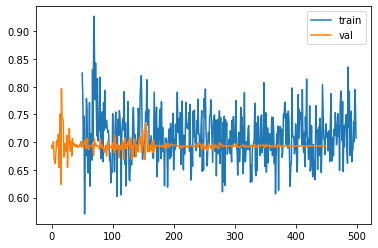

In [34]:
plt.plot(list(range(len(loss_train_history)))[50:], loss_train_history[50:], loss_val_history[50:])
plt.legend(["train", "val"])
plt.show()

In [0]:
torch.save(model.state_dict(), 'drive/My Drive/dl_noise_classification/20_train_epochs_500_pretrained_VGG.pth')

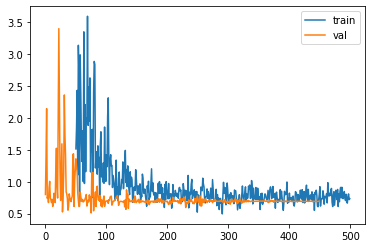

In [28]:
plt.plot(list(range(len(loss_train_history)))[50:], loss_train_history[50:], loss_val_history[50:])
plt.legend(["train", "val"])
plt.show()

In [0]:
plt.savefig('drive/My Drive/dl_noise_classification/train_val_loss_3.jpg')

<Figure size 432x288 with 0 Axes>

## Тестовая выборка и data loader

In [0]:
test_paths = im_paths[20:30]
test_dataset = ImageDataset(test_paths, val_transforms)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10, shuffle=True, num_workers=0)

## Загрузка обученной модели

In [36]:
params_dict = torch.load('drive/My Drive/dl_noise_classification/20_train_500_epochs_vgg_best_val')
#model = models.resnet152(pretrained=False)
#model.fc = torch.nn.Linear(model.fc.in_features, 2)
model.load_state_dict(params_dict)
model.eval()

num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(num_features, 2)]) # Add our layer with 2 outputs
model.classifier = torch.nn.Sequential(*features)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)

cuda:0


In [37]:
from tqdm import tqdm

test_predictions = []
test_img_sigmas = []
test_true = []
for inputs, labels, sigmas in tqdm(test_dataloader):
    test_true.append(labels)
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_sigmas.extend(sigmas)
    
y_pred = np.concatenate(test_predictions)
y_true = np.concatenate(test_true)

100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


In [38]:
print(y_pred)

[ 0.5103151  0.5103151  0.5103151  0.5103151  0.5103151  0.5103151
  0.5103151  0.5103151  0.5103151  0.5103151]


In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score


## ROC Curve

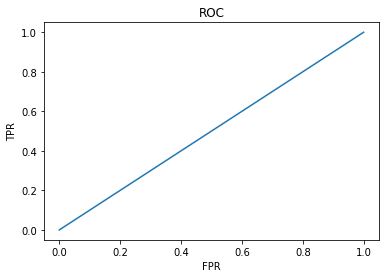

In [40]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr, tpr)

In [41]:
thresholds

array([ 1.5103152,  0.5103151], dtype=float32)

In [42]:
y_true

array([0, 0, 1, 0, 1, 0, 1, 1, 1, 0])

In [43]:
print("AUC: {}".format(roc_auc_score(y_true, y_pred)))


AUC: 0.5


## Точность в зависимости от порога

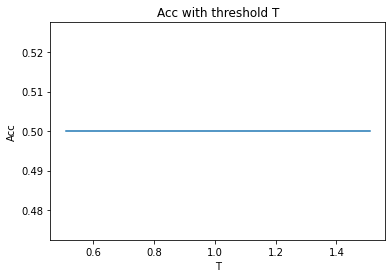

In [44]:
acc_history = []
t_history = []
for thresh in thresholds:
    y_hat = np.copy(y_pred)
    y_hat[y_hat > thresh] = 1
    y_hat[y_hat <= thresh] = 0
    accuracy = accuracy_score(y_true, y_hat)

    t_history.append(thresh)
    acc_history.append(accuracy)
    #print("Accuracy: {}, with threshold: {}".format(accuracy, thresh))

plt.title('Acc with threshold T')
plt.xlabel('T')
plt.ylabel('Acc')
plt.plot(t_history, acc_history)


array([ 0.47227594,  0.9996625 ,  0.5525067 ,  0.5744043 ,  0.5718775 ,
        0.60436624,  0.23836468,  0.659989  ,  0.5298564 ,  0.13553543,
        0.36954176,  0.5124735 ,  0.52312505,  0.52708185,  0.5880793 ,
        0.45013088,  0.56109136,  0.57235265,  0.5711936 ,  0.12979674,
        0.5353847 ,  0.6422717 ,  0.5695753 ,  0.59789217,  0.31670642,
        0.54615486,  0.47783807,  0.03903731,  0.5645977 ,  0.5616492 ], dtype=float32)